<a href="https://colab.research.google.com/github/TouchSeyha/Machine-Learning-Project/blob/main/TestChestX_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Step 1: Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from google.colab import drive

In [13]:
# Step 2: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
data_dir = '/content/drive/MyDrive/Colab_Machine_Learning/chest_xray'

# ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Validation data generator
val_generator = test_val_datagen.flow_from_directory(
    os.path.join(data_dir, 'val'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Test data generator
test_generator = test_val_datagen.flow_from_directory(
    os.path.join(data_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [15]:
# Load pre-trained ResNet50 model + higher level layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [16]:
# Add custom layers on top of ResNet50
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)  # Sigmoid for binary classification

# Define the model
model = Model(inputs=base_model.input, outputs=x)

In [18]:
# Step 3: Load and Preprocess Dataset
def load_images_from_folder(folder, img_size=(150, 150)):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, img_size)
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

# Update these paths to your dataset location in Google Drive
train_folder = '/content/drive/MyDrive/Colab_Machine_Learning/chest_xray/train'
test_folder = '/content/drive/MyDrive/Colab_Machine_Learning/chest_xray/test'

# Load datasets
X_train, y_train = load_images_from_folder(train_folder)
X_test, y_test = load_images_from_folder(test_folder)

In [19]:
# Step 4: Encode Labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [20]:
# Step 5: Split the Training Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [21]:
# Step 6: Normalize the Data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

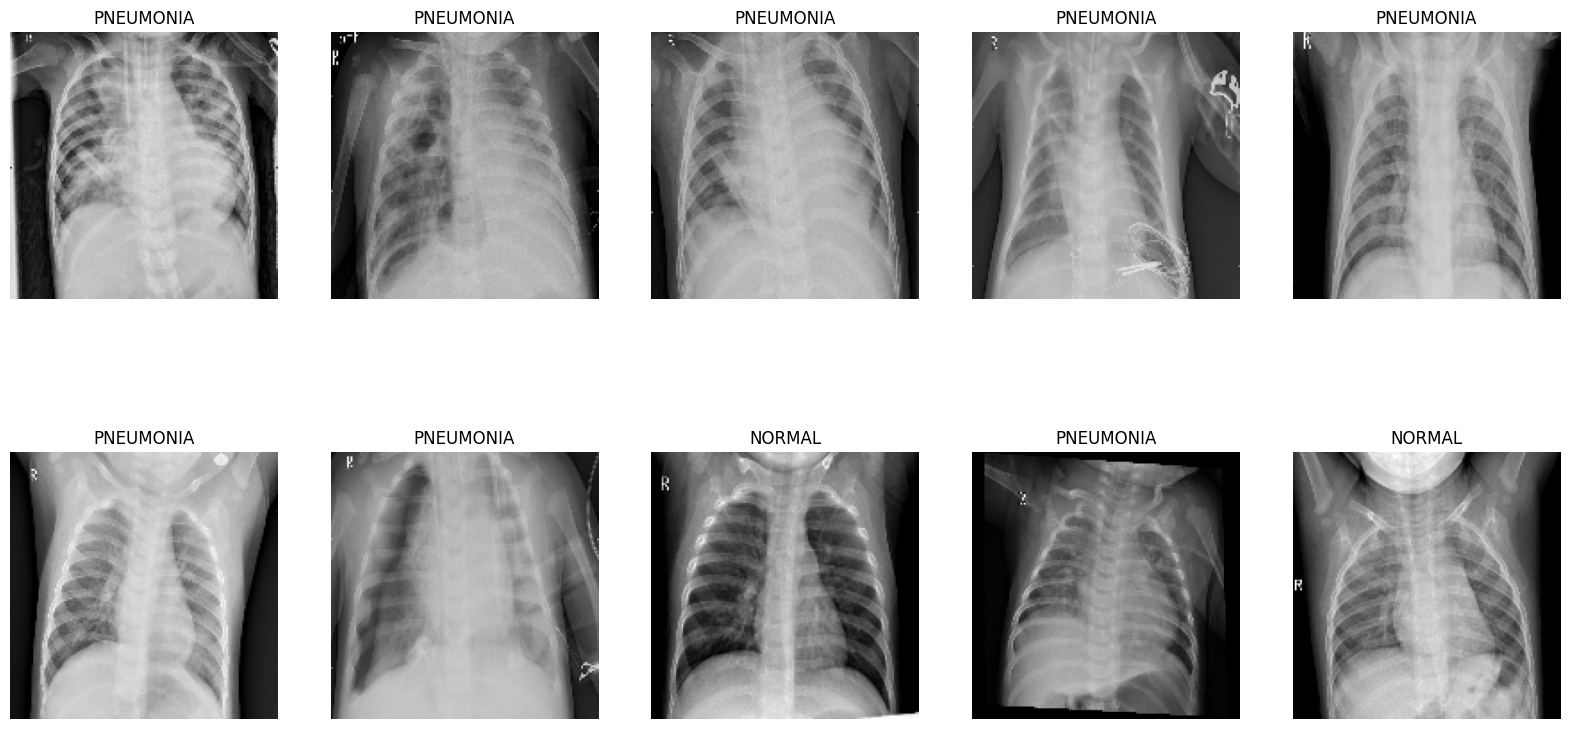

In [22]:
# Step 7: Display Sample Images
def display_images(images, labels, categories, num_images=10):
    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(images[i])
        plt.title(categories[labels[i]])
        plt.axis('off')
    plt.show()

# Display sample images from the training set
display_images(X_train, y_train, categories=['NORMAL', 'PNEUMONIA'])

In [23]:
# Step 8: Check the Shape of the Dataset
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (4172, 150, 150, 3)
Validation set shape: (1044, 150, 150, 3)
Test set shape: (624, 150, 150, 3)


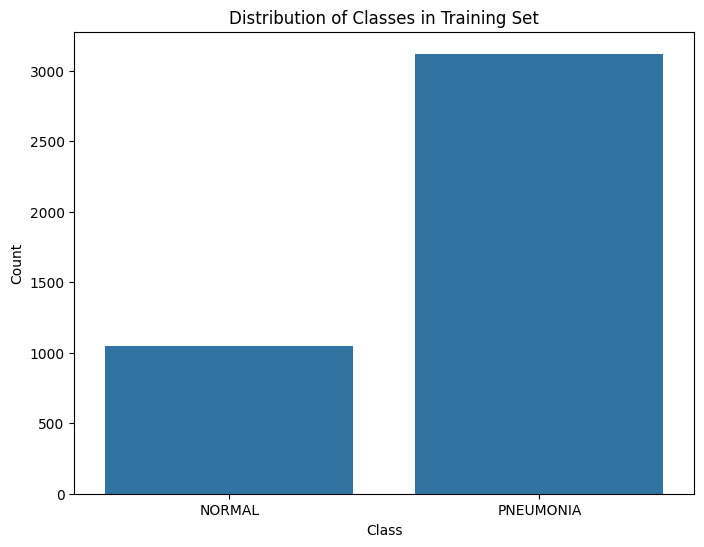

In [24]:
# Step 9: Plot Class Distribution in the Training Set
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train)
plt.title("Distribution of Classes in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=['NORMAL', 'PNEUMONIA'])
plt.show()

In [25]:
# Step 10: Check for Missing Images
def check_missing_images(images):
    missing_count = sum([1 for img in images if np.all(img == 0)])
    return missing_count

missing_images_train = check_missing_images(X_train)
missing_images_val = check_missing_images(X_val)
missing_images_test = check_missing_images(X_test)

print("Missing images in training set:", missing_images_train)
print("Missing images in validation set:", missing_images_val)
print("Missing images in test set:", missing_images_test)

Missing images in training set: 0
Missing images in validation set: 0
Missing images in test set: 0


In [26]:
# Step 11: Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [27]:
# Step 12: Build the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
# Step 13: Train the Model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
131/131 [==============================] - 41s 235ms/step - loss: 0.5793 - accuracy: 0.7476 - val_loss: 0.5926 - val_accuracy: 0.7213
Epoch 2/10
131/131 [==============================] - 27s 203ms/step - loss: 0.5748 - accuracy: 0.7483 - val_loss: 0.6240 - val_accuracy: 0.7213
Epoch 3/10
131/131 [==============================] - 25s 187ms/step - loss: 0.5720 - accuracy: 0.7483 - val_loss: 0.6039 - val_accuracy: 0.7213
Epoch 4/10
131/131 [==============================] - 26s 199ms/step - loss: 0.5694 - accuracy: 0.7483 - val_loss: 0.6025 - val_accuracy: 0.7213
Epoch 5/10
131/131 [==============================] - 27s 204ms/step - loss: 0.5696 - accuracy: 0.7483 - val_loss: 0.5937 - val_accuracy: 0.7213
Epoch 6/10
131/131 [==============================] - 27s 203ms/step - loss: 0.5676 - accuracy: 0.7483 - val_loss: 0.5921 - val_accuracy: 0.7213
Epoch 7/10
131/131 [==============================] - 25s 188ms/step - loss: 0.5669 - accuracy: 0.7483 - val_loss: 0.5938 - val_ac

In [29]:
# Step 14: Evaluate the Model
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow(X_test, y_test, batch_size=32)

test_loss, test_acc = model.evaluate(test_generator)
print("Test accuracy:", test_acc)

20/20 [==============================] - 1s 27ms/step - loss: 0.7140 - accuracy: 0.6250
Test accuracy: 0.625


In [30]:
# Step 15: Save the Model
model.save('/content/drive/My Drive/Colab_Machine_Learning/chest_xray_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
